In [1]:
import sys
sys.path.append('../..') # Asegúrate de que Python pueda encontrar el paquete src

# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from src.physics.pulses import GaussianPulse1D, format_value
from src.physics.crystals import KTPCrystal, KTPCrystal_Kato
from src.physics.nonlinear_optics import PhaseMatching
from src.physics.nonlinear_optics import second_harmonic_generation

/mnt/c/Users/rebel/Unal_code/Simulacion láser UNAL/SHG and PDC simulation/notebooks/simulaciones/../../src/physics/nonlinear_optics.py:26: SyntaxWarning: invalid escape sequence '\o'
  """


In [2]:
# Parámetros iniciales
L = 0.0004  # Longitud de la cavidad en metros (0.4 mm)
gaussian_steps = 1000  # Número de pasos para la simulación del pulso gaussiano 

# Parámetros del pulso en longitud de onda
input_width_wl = 44e-9  # FWHM en metros (44 nm)
fundamental_wavelength = 795e-9  # Longitud de onda central en metros (795 nm)
fundamental_wavelength_um = fundamental_wavelength * 1e6  # en μm (0.795 μm)

# Inicializar pulso en longitud de onda
input_pulse = GaussianPulse1D(x0=fundamental_wavelength, FWHM=input_width_wl, steps=gaussian_steps, domain_width_std=5)
sigma_wavelength = input_pulse.standard_deviation()  # ~1.8728e-08 m
wavelength, A_lambda = input_pulse.generate_pulse(normalization=True)
wavelength, I_lambda = input_pulse.generate_intensity()

# Conversión a frecuencia angular (rad/s)
c = 299792458  # Velocidad de la luz en m/s
fundamental_frequency = 2 * np.pi * c / fundamental_wavelength  # Frecuencia angular central (rad/s)
sigma_frequency = (2 * np.pi * c) / (fundamental_wavelength ** 2) * sigma_wavelength  # Desviación en rad/s
FWHM_frequency = sigma_frequency * 2 * np.sqrt(2 * np.log(2))  # FWHM en rad/s

# Inicializar pulso en frecuencia
input_pulse_omega = GaussianPulse1D(x0=fundamental_frequency, FWHM=FWHM_frequency, steps=gaussian_steps, domain_width_std=5)
frequencies, A_omega = input_pulse_omega.generate_pulse(normalization=True)
frequencies, I_omega = input_pulse_omega.generate_intensity(normalization=True)

# Parámetros para SHG
SHG_frequencies = 2 * frequencies  # Frecuencias de la segunda armónica
SHG_wavelength = fundamental_wavelength / 2  # ~397.5 nm
SHG_wavelength_um = SHG_wavelength * 1e6  # ~0.3975 μm

# Imprimir parámetros
print("Parameters of the Gaussian pulse in wavelength domain:")
print("-" * 60)
pulse_dict = input_pulse.as_dict()
for key, value in pulse_dict.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")

print("\n")
print("Parameters of the Gaussian pulse in frequency domain:")
print("-" * 60)
pulse_dict_omega = input_pulse_omega.as_dict()
for key, value in pulse_dict_omega.items():
    formatted_value = format_value(value)
    print(f"{key.replace('_', ' ').title()}: {formatted_value}")

Parameters of the Gaussian pulse in wavelength domain:
------------------------------------------------------------
Center: 7.9500e-07
Fwhm: 4.4000e-08
Sigma: 1.8685e-08
Steps: 1000
Domain Width Std: 5
Computed Fwhm: 4.4001e-08


Parameters of the Gaussian pulse in frequency domain:
------------------------------------------------------------
Center: 2.3694e+15
Fwhm: 1.3114e+14
Sigma: 5.5688e+13
Steps: 1000
Domain Width Std: 5
Computed Fwhm: 1.3114e+14


In [3]:
SHG_amplitud_no_QPM, frequencies, pmf_no_QPM = second_harmonic_generation(pulse_y=A_omega, pulse_x=frequencies, SHG_frequencies=SHG_frequencies,
                                                              fundamental_wavelength_um=fundamental_wavelength_um, cavity_length=L, poling_period_um=None)

poling_period_um = 3.19  # Período QPM en micrómetros AFINAR VALOR DEL CRISTAL
SHG_amplitud_with_QPM, frequencies, pmf_with_QPM = second_harmonic_generation(pulse_y=A_omega, pulse_x=frequencies, SHG_frequencies=SHG_frequencies,
                                                                fundamental_wavelength_um=fundamental_wavelength_um, cavity_length=L, poling_period_um=poling_period_um)

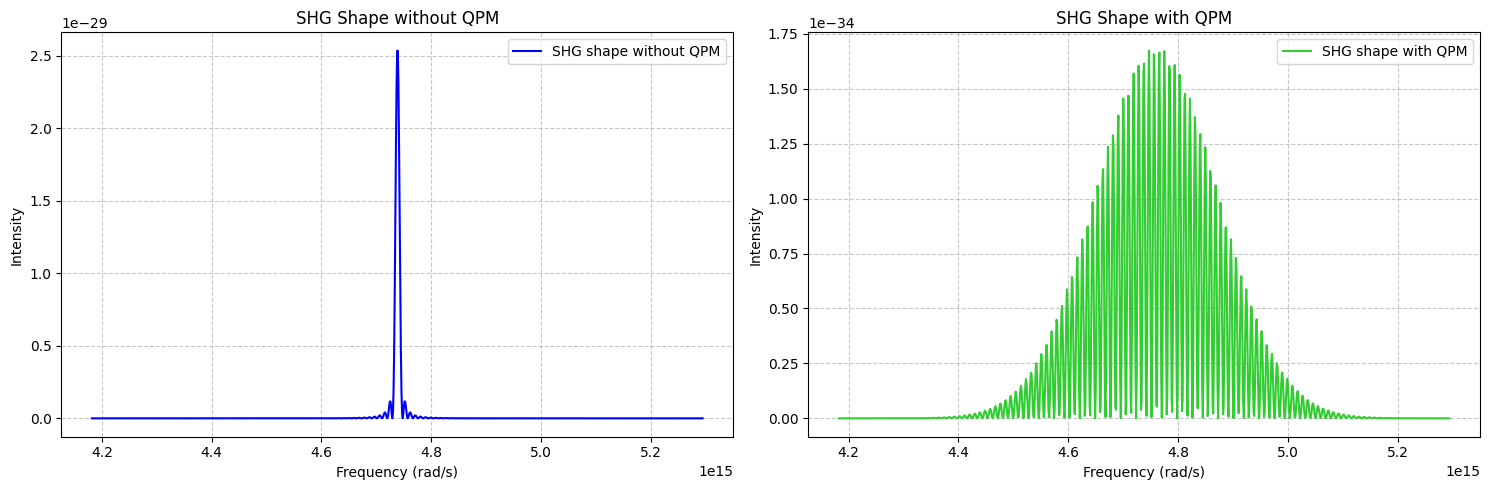

In [4]:
begin = 0
end = -1

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
SHG_frequencies_plot_interval = SHG_frequencies[begin: end]
SHG_shape_no_qpm_plot_interval = SHG_amplitud_no_QPM[begin: end]

plt.plot(SHG_frequencies_plot_interval, np.abs(SHG_shape_no_qpm_plot_interval)**2, label='SHG shape without QPM', color='blue')
plt.xlabel('Frequency (rad/s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('SHG Shape without QPM')
plt.ylabel('Intensity')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.subplot(1, 2, 2)

SHG_frequencies_plot_interval = SHG_frequencies[begin: end]
SHG_shape_with_qpm_plot_interval = SHG_amplitud_with_QPM[begin: end]

plt.plot(SHG_frequencies_plot_interval, np.abs(SHG_shape_with_qpm_plot_interval)**2, label='SHG shape with QPM', color='limegreen')
plt.xlabel('Frequency (rad/s)')
plt.title('SHG Shape with QPM')
plt.ylabel('Intensity')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.tight_layout()
plt.show()

### 3. Parametric Down Conversion (PDC) ###

Cálculo del JSA

El Joint Spectral Amplitude (JSA) se calcula como $JSA(\omega_s, \omega_i) = \alpha(\omega_s + \omega_i) \cdot \Phi(\omega_s, \omega_i)$, donde $\alpha$ es la envolvente del pulso de bombeo y $\Phi$ es la función de phase matching.

- $\alpha(\omega_p) = E_p(\omega_p)$, el campo del pulso de bombeo.
- $\Phi(\omega_s, \omega_i) = \text{sinc} \left( \frac{\Delta k L}{2} \right)$.

In [6]:
# PDC parameters
crystal_length = 5e-3 #in m

ktp = KTPCrystal()
pm = PhaseMatching(crystal=ktp, lambda_0_um=fundamental_wavelength_um)  # Calculate phase matching at fundamental wavelength

poling_period_um = 3.19  # Período QPM en micrómetros AFINAR VALOR DEL CRISTAL

# IMPORTANT:  the frequencies must be the ones corresponding to the second harmonic
pmf_no_qpm = pm.phase_matching_function(SHG_frequencies, L, Lambda_um=None)
pmf_with_qpm = pm.phase_matching_function(SHG_frequencies, L, Lambda_um=poling_period_um)

### 3.1: Definición de Parámetros para PDC
Este bloque define el pulso de bombeo (pump) y los rangos de frecuencias para señal ($\omega_s$) e idler ($\omega_i$). El JSA se calculará en un grid 2D de $\omega_s$ y $\omega_i$, conservando $\omega_p = \omega_s + \omega_i $.

- Pulso de bombeo: Centrado en $\omega_p \approx 2.3694 \times 10^{15} \, \text{rad/s} $.
- Rango de frecuencias: Usamos un grid de 100 x 100 puntos para $\omega_s$  y $\omega_i$.
- Phase Matching: Usamos QPM con $\Lambda = 3.19 \, \mu\text{m} $.

In [ ]:
# Parámetros para PDC
N = 100  # Resolución del grid para JSA
omega_s_range = np.linspace(SHG_frequencies.min(), SHG_frequencies.max(), N)  # Rango para señal
omega_i_range = np.linspace(SHG_frequencies.min(), SHG_frequencies.max(), N)  # Rango para idler
omega_s_grid, omega_i_grid = np.meshgrid(omega_s_range, omega_i_range)

# Asegurar conservación de energía (ajustar idler dinámicamente)
omega_p_grid = omega_s_grid + omega_i_grid
mask = np.abs(omega_p_grid - SHG_frequencies.mean()) < 5 * (SHG_frequencies.max() - SHG_frequencies.min()) / 2
omega_s_grid = omega_s_grid[mask]
omega_i_grid = omega_i_grid[mask]

# Parámetros del cristal
L = 4e-3  # Longitud del cristal (m)
Lambda_um = 3.19  # Período QPM (μm)
ktp = KTPCrystal(temperature=25.0)
pm = PhaseMatching(crystal=ktp, L=L, lambda_0_um=0.795)

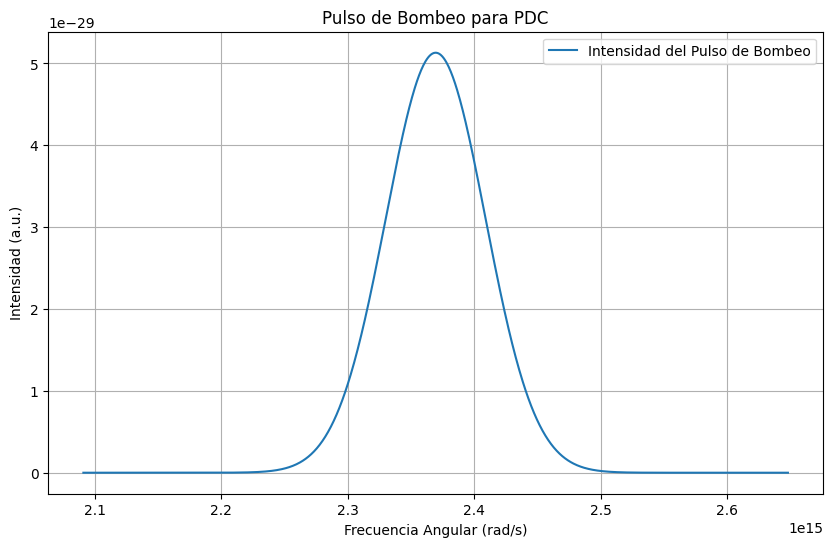

In [15]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt


# Define KTPCrystal class
class KTPCrystal:
    def __init__(self, temperature=25.0):
        self.B1, self.C1 = 3.0065, 0.03889e-6
        self.B2, self.C2 = 0.03961, 0.01224e-6
        self.temperature = temperature

    def sellmeier(self, wavelength_um):
        lambda_sq = wavelength_um ** 2
        n_sq = 1 + (self.B1 * lambda_sq) / (lambda_sq - self.C1) + (self.B2 * lambda_sq) / (lambda_sq - self.C2)
        return np.sqrt(n_sq)

    def n_omega(self, omega):
        c = 299792458
        lambda_um = 2 * np.pi * c / omega * 1e6
        return self.sellmeier(lambda_um)

# Define PhaseMatching class
class PhaseMatching:
    def __init__(self, crystal, L, lambda_0_um):
        self.crystal = crystal
        self.L = L
        self.lambda_0_um = lambda_0_um

    def phase_matching_function(self, frequencies, L=None, Lambda_um=None):
        L = self.L if L is None else L
        c = 299792458
        k_2omega = frequencies * self.crystal.n_omega(frequencies) / c
        k_omega = (frequencies / 2) * self.crystal.n_omega(frequencies / 2) / c
        delta_k = k_2omega - 2 * k_omega
        if Lambda_um is not None:
            Lambda = Lambda_um * 1e-6
            delta_k_eff = delta_k - 2 * np.pi / Lambda
        else:
            delta_k_eff = delta_k
        return np.sin(delta_k_eff * L / 2) / (delta_k_eff * L / 2 + 1e-10)

# Parámetros del pulso de bombeo (del Bloque 1)
omega_p = 2.3694e15  # Frecuencia central del bombeo (rad/s)
FWHM_omega_p = 1.3114e14  # FWHM del pulso de bombeo (rad/s)
sigma_omega_p = FWHM_omega_p / (2 * np.sqrt(2 * np.log(2)))  # ~5.5688e13 rad/s

# Inicializar el pulso de bombeo
pump_pulse = GaussianPulse1D(x0=omega_p, FWHM=FWHM_omega_p, steps=1000, domain_width_std=5)
omega_pump, A_pump = pump_pulse.generate_pulse(normalization=True)

# Parámetros para PDC
N = 100  # Resolución del grid para JSA (N x N)
omega_s_range = np.linspace(omega_p / 2 - 5 * sigma_omega_p / 2, omega_p / 2 + 5 * sigma_omega_p / 2, N)  # Rango para señal
omega_i_range = omega_p - omega_s_range  # Idler para conservar energía

# Parámetros del cristal (del Bloque 2)
L = 4e-3  # Longitud del cristal (m)
Lambda_um = 3.19  # Período QPM (μm)
fundamental_wavelength_um = 0.795  # μm
ktp = KTPCrystal(temperature=25.0)
pm = PhaseMatching(crystal=ktp, L=L, lambda_0_um=fundamental_wavelength_um)

# Visualización del pulso de bombeo
plt.figure(figsize=(10, 6))
plt.plot(omega_pump, np.abs(A_pump)**2, label='Intensidad del Pulso de Bombeo')
plt.xlabel('Frecuencia Angular (rad/s)')
plt.ylabel('Intensidad (a.u.)')
plt.title('Pulso de Bombeo para PDC')
plt.legend()
plt.grid(True)
plt.show()

### 3.2 Cálculo del JSA
El Joint Spectral Amplitude (JSA) se calcula como JSA(\( \omega_s \), \( \omega_i \)) = \( \alpha(\omega_s + \omega_i) \cdot \Phi(\omega_s, \omega_i) \), donde \( \alpha \) es la envolvente del pulso de bombeo y \( \Phi \) es la función de phase matching.

- $\alpha(\omega_p) = E_p(\omega_p)$, el campo del pulso de bombeo.
- $\Phi(\omega_s, \omega_i) = \text{sinc} \left( \frac{\Delta k L}{2} \right)$.

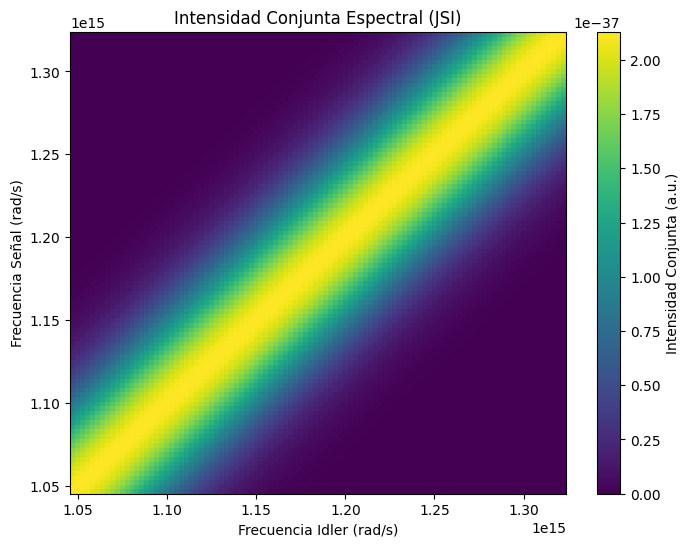

JSA máximo: 4.6153e-19


In [16]:
from scipy.interpolate import interp1d



# Función de envolvente del pulso de bombeo
def alpha(omega_s, omega_i):
    omega_p = omega_s + omega_i  # Conservación de energía
    interp_func = interp1d(omega_pump, A_pump, kind='cubic', fill_value=0, bounds_error=False)
    return interp_func(omega_p)

# Función de phase matching para PDC
def phi(omega_s, omega_i):
    omega_p = omega_s + omega_i
    k_p = omega_p * ktp.n_omega(omega_p) / c
    k_s = omega_s * ktp.n_omega(omega_s) / c
    k_i = omega_i * ktp.n_omega(omega_i) / c
    delta_k = k_p - k_s - k_i
    if Lambda_um is not None:
        Lambda = Lambda_um * 1e-6
        delta_k_eff = delta_k - 2 * np.pi / Lambda  # Orden m=1 para QPM
    else:
        delta_k_eff = delta_k
    sinc = np.sin(delta_k_eff * L / 2) / (delta_k_eff * L / 2 + 1e-10)
    phase = np.exp(1j * delta_k_eff * L / 2)
    return sinc * phase

# Cálculo del JSA en el grid 2D
JSA = np.zeros((N, N), dtype=complex)
for i in range(N):
    for j in range(N):
        JSA[i, j] = alpha(omega_s_range[i], omega_i_range[j]) * phi(omega_s_range[i], omega_i_range[j])

# Visualización del JSA
plt.figure(figsize=(8, 6))
plt.imshow(np.abs(JSA)**2, extent=[omega_i_range.min(), omega_i_range.max(), omega_s_range.min(), omega_s_range.max()], origin='lower', aspect='auto')
plt.colorbar(label='Intensidad Conjunta (a.u.)')
plt.xlabel('Frecuencia Idler (rad/s)')
plt.ylabel('Frecuencia Señal (rad/s)')
plt.title('Intensidad Conjunta Espectral (JSI)')
plt.show()

# Verificación
print(f"JSA máximo: {np.max(np.abs(JSA)):.4e}")

In [ ]:
class PhaseMatching:
    def __init__(self, crystal: KTPCrystal, lambda_0_um: float):
        """
        Initializes the PhaseMatching.

        Parameters
        ----------
        crystal : KTPCrystal
            The KTP crystal instance used for optical properties.
        lambda_0_um : float
            The fundamental wavelength in micrometers (um).
        """
        self.crystal = crystal
        self.lambda_0_um = lambda_0_um 
        self.c = KTPCrystal.SPEED_OF_LIGHT_M_PER_S
        self.omega_0 = 2 * np.pi * self.c / (self.lambda_0_um * 1e-6)  # Frecuencia fundamental (rad/s)

    def phase_mismatch(self, omega: Union[float, np.ndarray], axis: str = 'nz') -> Union[float, np.ndarray]:
        """
        Calculates the phase mismatch Delta k(omega) for second harmonic generation (SHG). This approximation
        is valid for small deviations of $\omega$ around $2\omega_0$ and assumes that the GVM dominates the 
        phase mismatch in ultrashort or dispersive pulse systems.

        Parameters
        ----------
        omega : float or array
            The second-harmonic frequencies in rad/s.
        axis : str, optional
            The optical axis ('nx', 'ny', 'nz'). Default is 'nz'.

        Returns
        -------
        float or array
            The phase mismatch (delta_k) in m^-1.

        Notes
        -----
        The phase mismatch is calculated using:
        delta_k = (1/v_g(2*omega_0) - 1/v_g(omega_0)) * (omega - 2*omega_0)
        where:
        - omega_0 is the fundamental frequency (stored in self.omega_0),
        - omega are the second-harmonic frequencies,
        - 2*omega_0 is the second-harmonic central frequency.
        """
        omega = np.asarray(omega)
        omega_SHG_0 = 2 * self.omega_0  # Central frequency of the second harmonic

        # Convert frequencies to wavelengths (in μm) for group velocity calculation
        lambda_0_um = self.lambda_0_um
        lambda_shg_0_um = (2 * np.pi * self.c / omega_SHG_0) * 1e6  # convert to micrometers

        # Calculate group velocities (in m/s)
        v_g_omega0 = self.crystal.group_velocity(lambda_0_um, axis=axis)
        v_g_2omega0 = self.crystal.group_velocity(lambda_shg_0_um, axis=axis)
        
        # Validate group velocities
        if np.any(np.isnan(v_g_omega0)) or np.any(np.isnan(v_g_2omega0)) or np.any(np.isclose([v_g_omega0, v_g_2omega0], 0)):
            print("Warning: Invalid group velocity detected. Returning NaN.")
            return np.nan

        # Calculate Group Velocity Mismatch (GVM) term in s/m
        gvm_term = (1 / v_g_2omega0) - (1 / v_g_omega0)

        # Calculate phase mismatch in m^-1
        delta_k = gvm_term * (omega - omega_SHG_0)
        return delta_k
    
    def phase_matching_function(self, omega: Union[float, np.ndarray], L: float, Lambda_um: float = None, axis: str = 'nz') -> Union[float, np.ndarray]:
        """
        Calculates the phase matching function Phi for second harmonic generation (SHG) with optional QPM.

        Parameters
        ----------
        omega : float or array
            The second-harmonic frequencies in rad/s.
        L : float
            The length of the crystal in meters. Must be positive.
        Lambda_um : float, optional
            The QPM grating period in micrometers (um). If None, standard phase matching is assumed.
        axis : str, optional
            The optical axis ('nx', 'ny', 'nz'). Default is 'nz'.

        Returns
        -------
        float or array
            The phase matching function Phi (dimensionless).

        Notes
        -----
        Phi = sinc((Δk - 2π/Λ) * L / 2) if Lambda_um is provided, else sinc(Δk * L / 2).
        Where Δk is calculated by phase_mismatch, and sinc(x) = sin(pi*x)/(pi*x).

        Raises
        ------
        ValueError
            If L is not positive.
        """
        if L <= 0:
            raise ValueError("Crystal length L must be positive.")

        omega = np.asarray(omega)
        delta_k = self.phase_mismatch(omega, axis=axis)

        if Lambda_um is not None:
            Lambda_m = Lambda_um * 1e-6  # Convert to meters
            delta_k_eff = delta_k - (2 * np.pi / Lambda_m)  # Effective phase mismatch with QPM
        else:
            delta_k_eff = delta_k

        arg = delta_k_eff * L / 2
        phi = np.sinc(arg / np.pi)  # np.sinc(x) = sin(pi*x)/(pi*x)
        return phi
    
    class KTPCrystal:
    """
    Represents a KTP crystal and provides methods to calculate its
    refractive index and related dispersion properties using a specific
    form of the Sellmeier equation with coefficients from a defined source.

    Attributes
    ----------
    sellmeier_coefficients : Dict[str, Dict[str, float]]
        A dictionary storing the Sellmeier coefficients for different
        crystal axes ('nx', 'ny', 'nz').

    Notes
    -----
    This class uses the Sellmeier equations and coefficients specifically
    from https://www.unitedcrystals.com/KTPProp.html, which have the form:
    n^2 = A + B / (lambda^2 - C) - D * lambda^2, where lambda is in micrometers (um).
    Be aware that other Sellmeier representations for KTP exist.

    The refractive index calculation assumes the wavelength is in micrometers (um).
    Speed of light is in meters per second (m/s).
    """

    # Define the Sellmeier coefficients as a class attribute, matching the source
    SELLMEIER_COEFFICIENTS: Dict[str, Dict[str, float]] = {
        "nx": {'a_k' : 3.0065, 'b_k' : 0.03901, 'c_k' : 0.04251, 'd_k' : 0.01327},
        "ny": {'a_k' : 3.0333, 'b_k' : 0.04154, 'c_k' : 0.04547, 'd_k' : 0.01408},
        "nz": {'a_k' : 3.3134, 'b_k' : 0.05694, 'c_k' : 0.05658, 'd_k' : 0.01682}
    }

    VALID_AXES = list(SELLMEIER_COEFFICIENTS.keys())

    # Añadimos la velocidad de la luz como una constante de clase
    SPEED_OF_LIGHT_M_PER_S: float = 299792458.0 # Velocidad de la luz en vacío en metros por segundo


    def __init__(self):
        """
        Initializes a KTPCrystal object.
        """
        # Puedes mantener esto si quieres la posibilidad de cambiar coeficientes
        # en el futuro, aunque ahora mismo usa los de clase.
        self.sellmeier_coefficients = self.SELLMEIER_COEFFICIENTS


    def refractive_index(self, wavelength_um: float, axis: str = 'nz') -> float:
        """
        Calculates the refractive index for a given wavelength and crystal axis
        using the specified Sellmeier equation.

        Uses a Sellmeier equation of the form:
        n^2 = A + B / (lambda^2 - C) - D * lambda^2
        where lambda is the wavelength in micrometers (um).

        Parameters
        ----------
        wavelength_um : float
            The wavelength in micrometers (um). Must be positive.
        axis : str, optional
            The crystal axis ('nx', 'ny', or 'nz'). Defaults to 'nz'.

        Returns
        -------
        float or nan
            The calculated refractive index (dimensionless). Returns NaN if the input
            axis is invalid, wavelength is not positive, or n^2 is negative
            or results from division by zero (lambda^2 == C).

        Raises
        ------
        ValueError
            If the provided axis is not one of 'nx', 'ny', or 'nz'.
            If the wavelength is not positive.
        """
        # 1. Validate input axis
        if axis not in self.VALID_AXES:
            raise ValueError(f"Invalid axis: {axis}. Must be one of {self.VALID_AXES}")

        # 2. Validate wavelength
        if wavelength_um <= 0:
            raise ValueError("Wavelength must be positive.")

        # Get coefficients for the specified axis
        coeffs = self.sellmeier_coefficients[axis]
        A = coeffs['a_k'] # Use A, B, C, D for formula clarity
        B = coeffs['b_k']
        C = coeffs['c_k']
        D = coeffs['d_k']

        lambda_sq = wavelength_um**2
        denominator = lambda_sq - C

        # Handle potential division by zero or near-zero denominator
        if np.isclose(denominator, 0):
             print(f"Warning: Wavelength squared ({lambda_sq:.4f}) is too close to C ({C}) for axis {axis}. Sellmeier equation has a pole here. Returning NaN.")
             return np.nan

        n_squared = A + (B / denominator) - (D * lambda_sq)

        # 3. Check if n^2 is non-negative before taking the square root
        if n_squared < 0:
             print(f"Warning: Calculated n^2 is negative ({n_squared:.4f}) for wavelength {wavelength_um} um on axis {axis}. Returning NaN.")
             return np.nan

        return np.sqrt(n_squared)


    def refractive_index_derivative_analytical(self, wavelength_um: float, axis: str = 'nz') -> float:
        """
        Calculates the first derivative of the refractive index (dn/dlambda)
        with respect to wavelength using the analytical Sellmeier formula derivative.

        The Sellmeier equation used is n^2 = A + B / (lambda^2 - C) - D * lambda^2.
        The analytical derivative is dn/dlambda = - (lambda / n) * (B / (lambda^2 - C)^2 + D).

        Parameters
        ----------
        wavelength_um : float
            The wavelength in micrometers (um). Must be positive.
        axis : str, optional
            The crystal axis ('nx', 'ny', or 'nz'). Defaults to 'nz'.

        Returns
        -------
        float or nan
            The calculated analytical derivative dn/dlambda in units of um^-1.
            Returns NaN if the input axis is invalid, wavelength is not positive,
            n is close to zero, or the denominator (lambda^2 - C) is close to zero.

        Raises
        ------
        ValueError
            If the provided axis is not one of 'nx', 'ny', or 'nz'.
            If the wavelength is not positive.

        Notes
        -----
        The units of the resulting derivative are in um^-1 (micrometers^-1).
        """
        # 1. Validate input axis and wavelength (re-use checks from refractive_index)
        if axis not in self.VALID_AXES:
            raise ValueError(f"Invalid axis: {axis}. Must be one of {self.VALID_AXES}")
        if wavelength_um <= 0:
            raise ValueError("Wavelength must be positive.")

        # Get coefficients for the specified axis
        coeffs = self.sellmeier_coefficients[axis]
        B = coeffs['b_k']
        C = coeffs['c_k']
        D = coeffs['d_k'] # Use D

        # Get the refractive index n at this wavelength
        n = self.refractive_index(wavelength_um, axis=axis)

        # Handle cases where n is NaN or very close to zero
        if np.isnan(n) or np.isclose(n, 0):
            print(f"Warning: Refractive index n is NaN or zero at {wavelength_um} um ({axis}) while calculating derivative. Returning NaN.")
            return np.nan

        lambda_sq = wavelength_um**2
        denominator_term = lambda_sq - C

        # Handle potential division by zero in the denominator term squared
        if np.isclose(denominator_term, 0):
             print(f"Warning: Wavelength squared ({lambda_sq:.4f}) is too close to C ({C}) for axis {axis} in derivative calculation. Sellmeier equation has a pole here. Returning NaN.")
             return np.nan

        # Implement the analytical derivative formula:
        # dn/dlambda = - (lambda / n) * (B / (lambda^2 - C)^2 + D)
        term1 = -wavelength_um / n
        term2 = (B / (denominator_term**2)) + D

        dn_dlambda = term1 * term2

        # Check if the result is NaN (can happen if intermediate steps produced NaN)
        if np.isnan(dn_dlambda):
             print(f"Warning: Analytical derivative calculation resulted in NaN at {wavelength_um} um ({axis}).")

        return dn_dlambda


    def group_index(self, wavelength_um: float, axis: str = 'nz') -> float:
        """
        Calculates the group refractive index for a given wavelength and crystal axis.

        Formula: n_g = n - lambda * (dn/dlambda)
        where n is the phase refractive index and dn/dlambda is its derivative.

        Parameters
        ----------
        wavelength_um : float
            The wavelength in micrometers (um). Must be positive.
        axis : str, optional
            The crystal axis ('nx', 'ny', or 'nz'). Defaults to 'nz'.

        Returns
        -------
        float or nan
            The calculated group index (dimensionless). Returns NaN if the phase index (n)
            or its derivative (dn/dlambda) cannot be computed or result in NaN.

        Raises
        ------
        ValueError
            If the provided axis is not one of 'nx', 'ny', or 'nz'.
            If the wavelength is not positive.
        """
        # Input validation is handled by the methods being called.

        n = self.refractive_index(wavelength_um, axis=axis)
        dn_dlambda = self.refractive_index_derivative_analytical(wavelength_um, axis=axis)

        # Check if either calculation resulted in NaN
        if np.isnan(n) or np.isnan(dn_dlambda):
            print(f"Warning: Cannot compute group index at {wavelength_um} um ({axis}) due to invalid n or dn/dlambda. Returning NaN.")
            return np.nan

        # Formula for group index: n_g = n - lambda_um * dn/dlambda_um
        # Units: dimensionless - um * um^-1 = dimensionless
        n_group = n - wavelength_um * dn_dlambda

        # Check if the result is NaN
        if np.isnan(n_group):
             print(f"Warning: Group index calculation resulted in NaN at {wavelength_um} um ({axis}).")

        return n_group


    def group_velocity(self, wavelength_um: float, axis: str = 'nz') -> float:
        """
        Calculates the group velocity in meters per second (m/s) for a given
        wavelength and crystal axis.

        Formula: v_g = c / n_g
        where c is the speed of light in vacuum and n_g is the group index.

        Parameters
        ----------
        wavelength_um : float
            The wavelength in micrometers (um). Must be positive.
        axis : str, optional
            The crystal axis ('nx', 'ny', or 'nz'). Defaults to 'nz'.

        Returns
        -------
        float or nan
            The calculated group velocity in meters per second (m/s).
            Returns NaN if the input wavelength is not positive, axis is invalid,
            or if the group index (n_g) cannot be computed or is NaN or close to zero.

        Raises
        ------
        ValueError
            If the provided axis is not one of 'nx', 'ny', or 'nz'.
            If the wavelength is not positive.
        """
        # Input validation is handled by the methods being called (refractive_index -> group_index).
        # However, validating here provides earlier feedback.
        if axis not in self.VALID_AXES:
            raise ValueError(f"Invalid axis: {axis}. Must be one of {self.VALID_AXES}")
        if wavelength_um <= 0:
            raise ValueError("Wavelength must be positive.")


        n_group = self.group_index(wavelength_um, axis=axis)

        # Check if group index is NaN or very close to zero
        if np.isnan(n_group) or np.isclose(n_group, 0):
            print(f"Warning: Cannot compute group velocity at {wavelength_um} um ({axis}) due to invalid or zero group index ({n_group}). Returning NaN.")
            return np.nan

        # Formula for group velocity (c in m/s, n_g dimensionless -> v_g in m/s)
        v_group_mps = self.SPEED_OF_LIGHT_M_PER_S / n_group

        # Check if the result is NaN
        if np.isnan(v_group_mps):
             print(f"Warning: Group velocity calculation resulted in NaN at {wavelength_um} um ({axis}).")


        return v_group_mps
    